In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
print(tf.__version__)

2.12.0


In [4]:
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
train_df = pd.read_csv('data/train.csv').drop('Date',axis=1)
val_df = pd.read_csv('data/val.csv').drop('Date',axis=1)
test_df = pd.read_csv('data/test.csv').drop('Date',axis=1)

print(train_df.shape, val_df.shape, test_df.shape)

(4596, 15) (1314, 15) (630, 15)


## `DataWindow` class 

In [6]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='Adj Close', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [7]:
def compile_and_fit(model, window, patience=3, max_epochs=1000):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [8]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## Baseline models 

In [9]:
multi_window = DataWindow(input_width=7, label_width=7, shift=7, label_columns=['Adj Close'])

### Repeat last value 

In [10]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 7, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 7, 1])

In [11]:
baseline_last = MultiStepLastBaseline(label_index=column_indices['Adj Close'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(multi_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(multi_window.test, verbose=0)

41/41 [==============================] - 0s 947us/step - loss: 2.6052 - mean_absolute_error: 0.8984


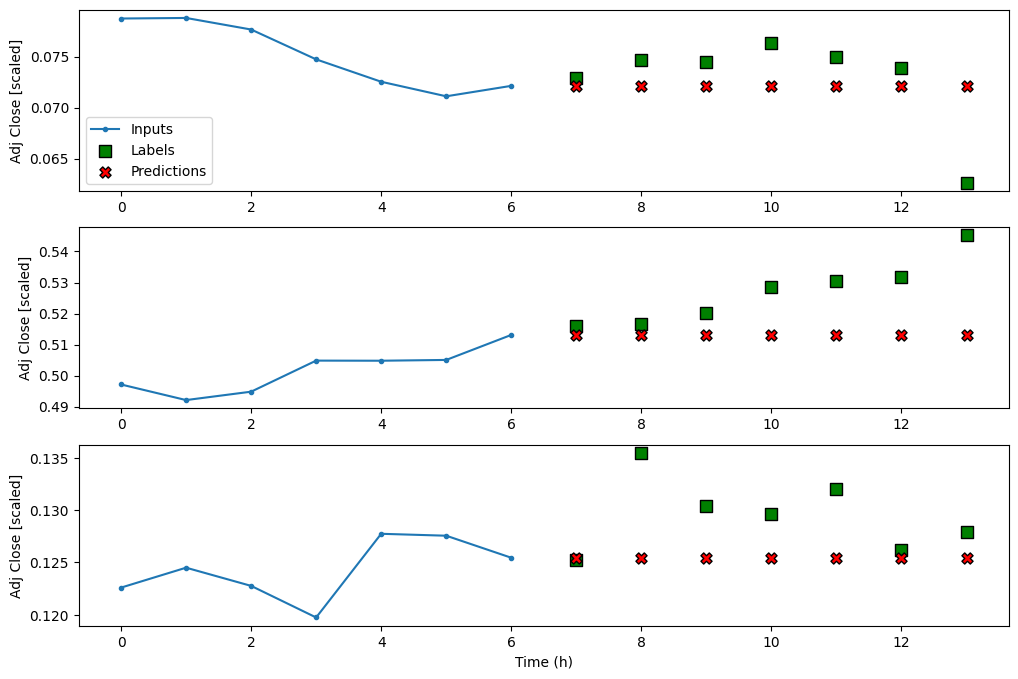

In [12]:
multi_window.plot(baseline_last)

plt.savefig('figures/CH18_F07_peixeiro.png', dpi=300)

### Repeat last day 

In [13]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [14]:
baseline_repeat = RepeatBaseline(label_index=column_indices['Adj Close'])

baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.val)
performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.test, verbose=0)

41/41 [==============================] - 0s 895us/step - loss: 2.6106 - mean_absolute_error: 0.9095


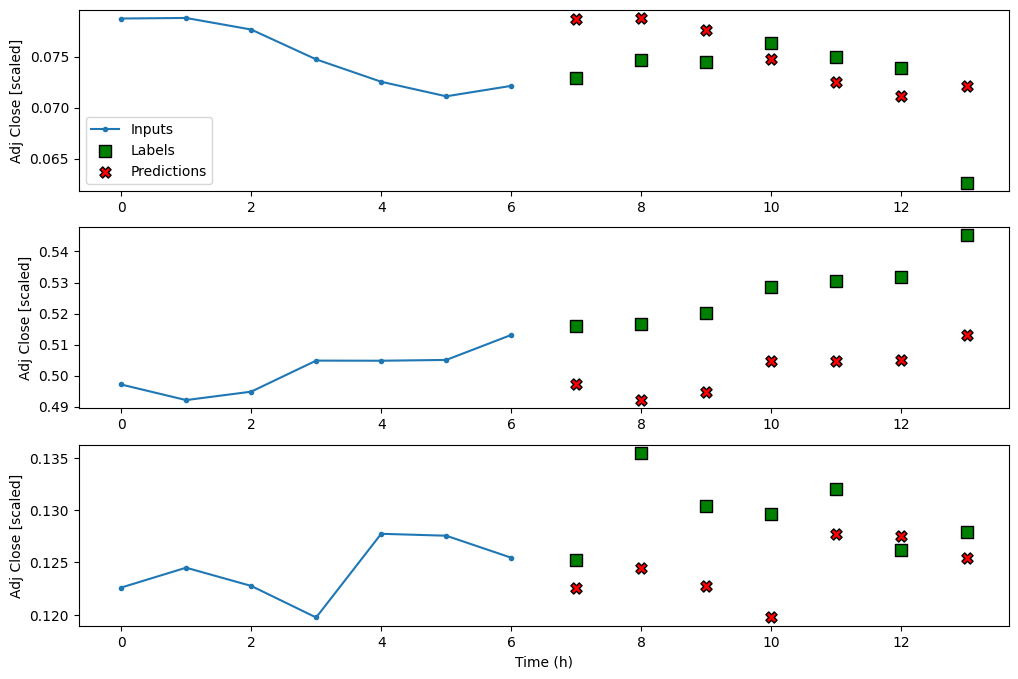

In [15]:
multi_window.plot(baseline_repeat)

plt.savefig('figures/CH18_F08_peixeiro.png', dpi=300)

## Linear model 

In [16]:
label_index = column_indices['Adj Close']
num_features = train_df.shape[1]

linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(linear, multi_window)

val_performance['Linear'] = linear.evaluate(multi_window.val)
performance['Linear'] = linear.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
144/144 [==============================] - 1s 2ms/step - loss: 0.0179 - mean_absolute_error: 0.0860 - val_loss: 0.3681 - val_mean_absolute_error: 0.5191
Epoch 2/1000
144/144 [==============================] - 0s 1ms/step - loss: 9.0567e-04 - mean_absolute_error: 0.0232 - val_loss: 0.0378 - val_mean_absolute_error: 0.1387
Epoch 3/1000
144/144 [==============================] - 0s 1ms/step - loss: 3.3629e-04 - mean_absolute_error: 0.0124 - val_loss: 0.0263 - val_mean_absolute_error: 0.1076
Epoch 4/1000
144/144 [==============================] - 0s 2ms/step - loss: 3.0774e-04 - mean_absolute_error: 0.0112 - val_loss: 0.0258 - val_mean_absolute_error: 0.1060
Epoch 5/1000
144/144 [==============================] - 0s 2ms/step - loss: 2.9685e-04 - mean_absolute_error: 0.0108 - val_loss: 0.0253 - val_mean_absolute_error: 0.1043
Epoch 6/1000
144/144 [==============================] - 0s 2ms/step - loss: 2.9148e-04 - mean_absolute_error: 0.0106 - val_loss: 0.0250 - val_mean_absolut

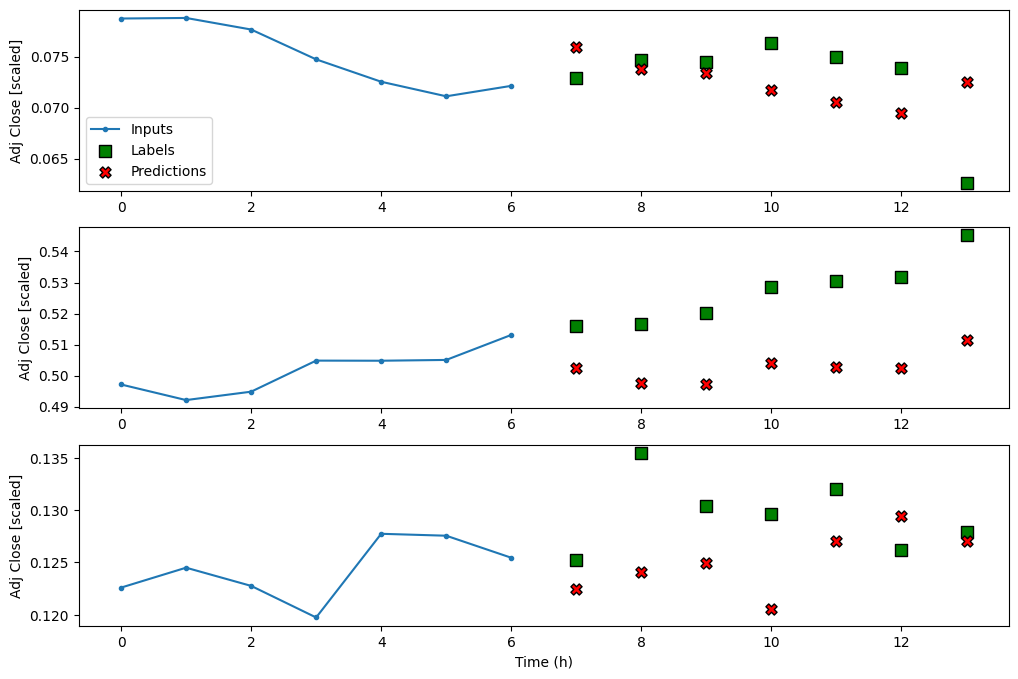

In [17]:
multi_window.plot(linear)

plt.savefig('figures/CH18_F09_peixeiro.png', dpi=300)

## Dense model 

In [18]:
dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(dense, multi_window)

val_performance['Dense'] = dense.evaluate(multi_window.val)
performance['Dense'] = dense.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
144/144 [==============================] - 1s 3ms/step - loss: 0.0103 - mean_absolute_error: 0.0474 - val_loss: 0.0575 - val_mean_absolute_error: 0.1741
Epoch 2/1000
144/144 [==============================] - 0s 2ms/step - loss: 2.9865e-04 - mean_absolute_error: 0.0111 - val_loss: 0.0336 - val_mean_absolute_error: 0.1233
Epoch 3/1000
144/144 [==============================] - 0s 2ms/step - loss: 2.9017e-04 - mean_absolute_error: 0.0107 - val_loss: 0.0425 - val_mean_absolute_error: 0.1446
Epoch 4/1000
144/144 [==============================] - 0s 2ms/step - loss: 2.9731e-04 - mean_absolute_error: 0.0109 - val_loss: 0.0480 - val_mean_absolute_error: 0.1578
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0423 - mean_absolute_error: 0.1458


## LSTM model 

In [19]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(lstm_model, multi_window)

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
144/144 [==============================] - 3s 8ms/step - loss: 0.0167 - mean_absolute_error: 0.0696 - val_loss: 3.7077 - val_mean_absolute_error: 1.4790
Epoch 2/1000
144/144 [==============================] - 1s 4ms/step - loss: 0.0012 - mean_absolute_error: 0.0210 - val_loss: 3.0633 - val_mean_absolute_error: 1.3071
Epoch 3/1000
144/144 [==============================] - 1s 4ms/step - loss: 4.1363e-04 - mean_absolute_error: 0.0135 - val_loss: 2.8520 - val_mean_absolute_error: 1.2388
Epoch 4/1000
144/144 [==============================] - 1s 3ms/step - loss: 3.2230e-04 - mean_absolute_error: 0.0116 - val_loss: 2.8051 - val_mean_absolute_error: 1.2223
Epoch 5/1000
144/144 [==============================] - 1s 4ms/step - loss: 3.1198e-04 - mean_absolute_error: 0.0113 - val_loss: 2.7730 - val_mean_absolute_error: 1.2086
Epoch 6/1000
144/144 [==============================] - 1s 4ms/step - loss: 3.0834e-04 - mean_absolute_error: 0.0112 - val_loss: 2.7585 - val_mean_absolute_er

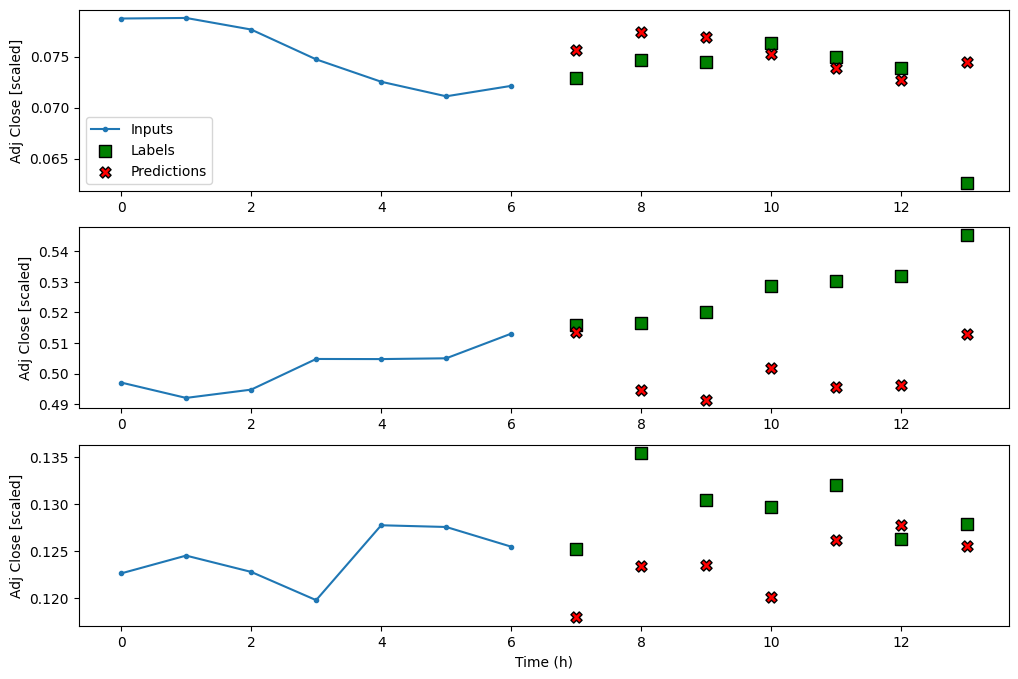

In [20]:
multi_window.plot(lstm_model)

plt.savefig('figures/CH18_F10_peixeiro.png', dpi=300)

## CNN model 

In [21]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 7
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

cnn_multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=7, label_columns=['Adj Close'])

In [22]:
cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_model, cnn_multi_window)

val_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.val)
performance['CNN'] = cnn_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
144/144 [==============================] - 1s 3ms/step - loss: 0.0097 - mean_absolute_error: 0.0464 - val_loss: 0.0525 - val_mean_absolute_error: 0.1677
Epoch 2/1000
144/144 [==============================] - 0s 2ms/step - loss: 3.4483e-04 - mean_absolute_error: 0.0122 - val_loss: 0.0388 - val_mean_absolute_error: 0.1388
Epoch 3/1000
144/144 [==============================] - 0s 2ms/step - loss: 3.2604e-04 - mean_absolute_error: 0.0116 - val_loss: 0.0375 - val_mean_absolute_error: 0.1363
Epoch 4/1000
144/144 [==============================] - 0s 2ms/step - loss: 3.0766e-04 - mean_absolute_error: 0.0111 - val_loss: 0.0328 - val_mean_absolute_error: 0.1241
Epoch 5/1000
144/144 [==============================] - 0s 2ms/step - loss: 3.1212e-04 - mean_absolute_error: 0.0111 - val_loss: 0.0485 - val_mean_absolute_error: 0.1623
Epoch 6/1000
144/144 [==============================] - 0s 2ms/step - loss: 3.2019e-04 - mean_absolute_error: 0.0113 - val_loss: 0.0410 - val_mean_absolut

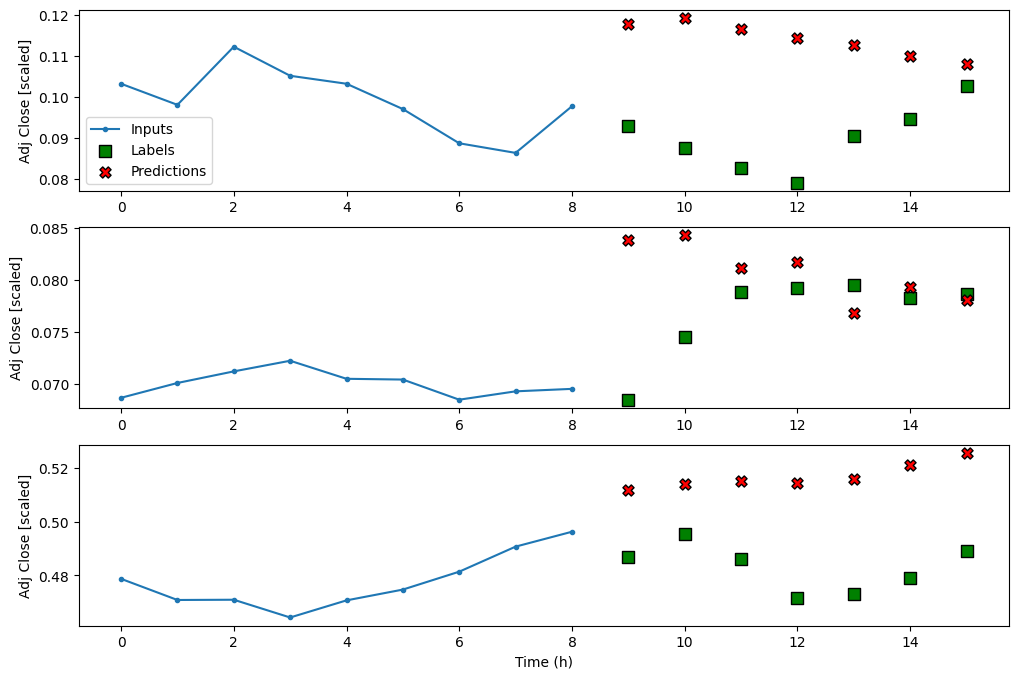

In [23]:
cnn_multi_window.plot(cnn_model)

plt.savefig('figures/CH18_F11_peixeiro.png', dpi=300)

## CNN + LSTM model 

In [24]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
144/144 [==============================] - 3s 6ms/step - loss: 0.0147 - mean_absolute_error: 0.0604 - val_loss: 4.5421 - val_mean_absolute_error: 1.6807
Epoch 2/1000
144/144 [==============================] - 1s 4ms/step - loss: 4.7460e-04 - mean_absolute_error: 0.0139 - val_loss: 4.2667 - val_mean_absolute_error: 1.6025
Epoch 3/1000
144/144 [==============================] - 1s 4ms/step - loss: 3.7850e-04 - mean_absolute_error: 0.0124 - val_loss: 4.0950 - val_mean_absolute_error: 1.5500
Epoch 4/1000
144/144 [==============================] - 1s 4ms/step - loss: 3.6000e-04 - mean_absolute_error: 0.0121 - val_loss: 4.0296 - val_mean_absolute_error: 1.5382
Epoch 5/1000
144/144 [==============================] - 1s 4ms/step - loss: 3.4002e-04 - mean_absolute_error: 0.0117 - val_loss: 3.9165 - val_mean_absolute_error: 1.5013
Epoch 6/1000
144/144 [==============================] - 1s 4ms/step - loss: 3.3658e-04 - mean_absolute_error: 0.0116 - val_loss: 3.8559 - val_mean_absolut

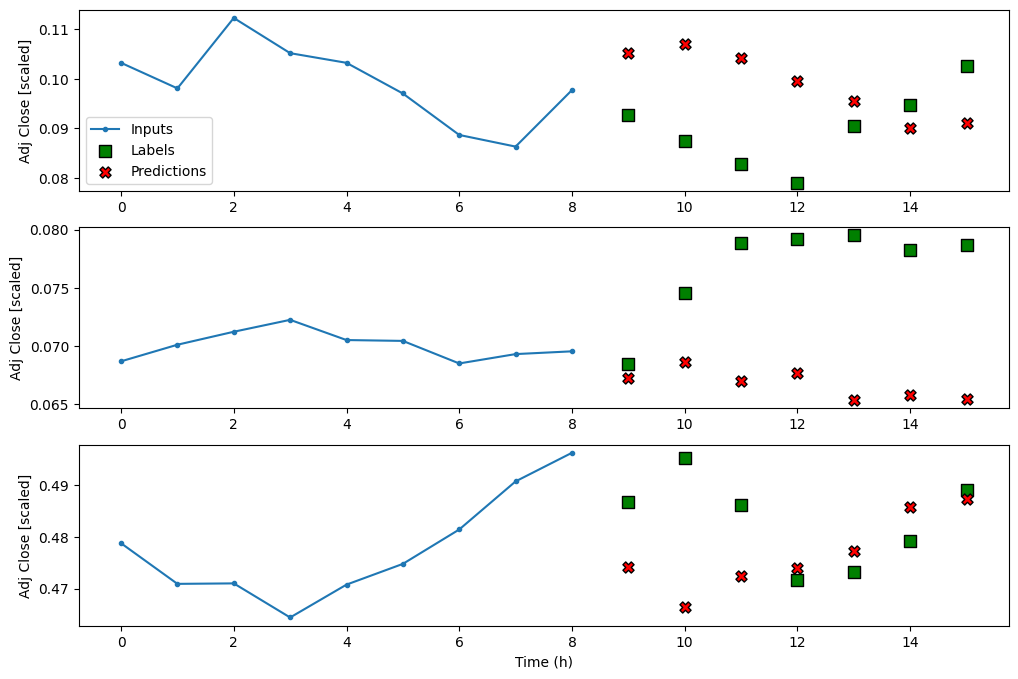

In [25]:
cnn_multi_window.plot(cnn_lstm_model)

plt.savefig('figures/CH18_F12_peixeiro.png', dpi=300)

## Autoregressive LSTM 

In [26]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
                
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        
        predictions.append(prediction)
        
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            
            prediction = self.dense(x)
            predictions.append(prediction)
        
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

In [27]:
AR_LSTM = AutoRegressive(units=32, out_steps=7)

history = compile_and_fit(AR_LSTM, multi_window)

val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
144/144 [==============================] - 3s 7ms/step - loss: 0.0092 - mean_absolute_error: 0.0477 - val_loss: 4.4920 - val_mean_absolute_error: 1.6693
Epoch 2/1000
144/144 [==============================] - 1s 4ms/step - loss: 5.8670e-04 - mean_absolute_error: 0.0173 - val_loss: 4.1871 - val_mean_absolute_error: 1.5841
Epoch 3/1000
144/144 [==============================] - 1s 4ms/step - loss: 4.8775e-04 - mean_absolute_error: 0.0151 - val_loss: 4.1291 - val_mean_absolute_error: 1.5679
Epoch 4/1000
144/144 [==============================] - 1s 4ms/step - loss: 3.7619e-04 - mean_absolute_error: 0.0129 - val_loss: 3.9914 - val_mean_absolute_error: 1.5268
Epoch 5/1000
144/144 [==============================] - 1s 4ms/step - loss: 2.9480e-04 - mean_absolute_error: 0.0113 - val_loss: 3.8540 - val_mean_absolute_error: 1.4815
Epoch 6/1000
144/144 [==============================] - 1s 4ms/step - loss: 2.7306e-04 - mean_absolute_error: 0.0107 - val_loss: 3.8278 - val_mean_absolut

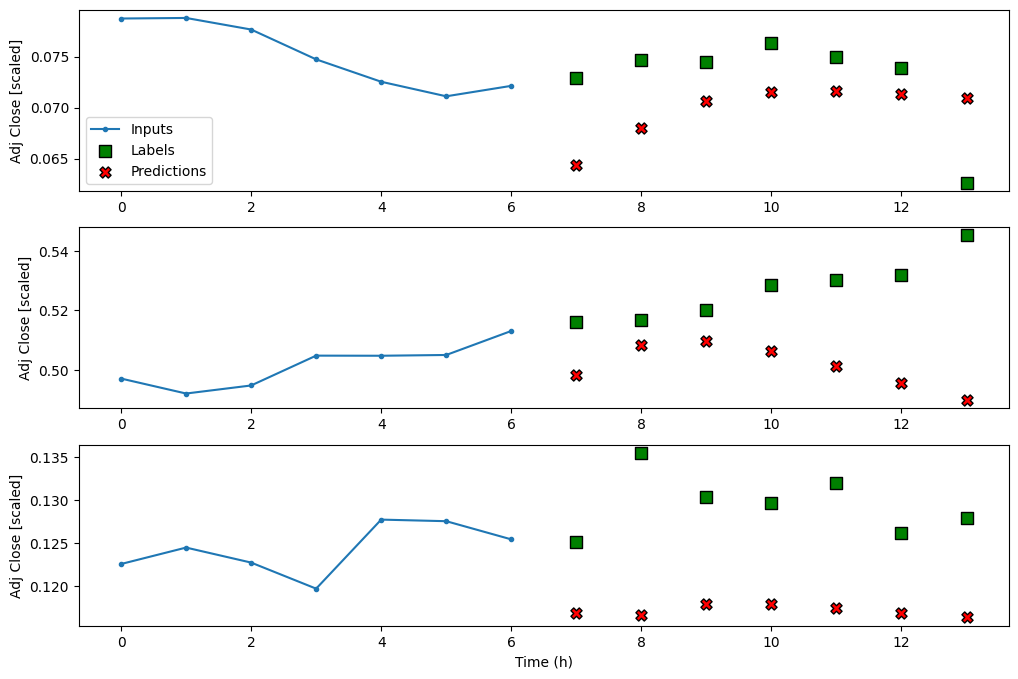

In [28]:
multi_window.plot(AR_LSTM)

plt.savefig('figures/CH18_F13_peixeiro.png', dpi=300)

In [29]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
144/144 [==============================] - 3s 6ms/step - loss: 0.0142 - mean_absolute_error: 0.0589 - val_loss: 4.5040 - val_mean_absolute_error: 1.6623
Epoch 2/1000
144/144 [==============================] - 1s 4ms/step - loss: 4.7607e-04 - mean_absolute_error: 0.0139 - val_loss: 4.2287 - val_mean_absolute_error: 1.5856
Epoch 3/1000
144/144 [==============================] - 1s 4ms/step - loss: 3.7653e-04 - mean_absolute_error: 0.0124 - val_loss: 4.1100 - val_mean_absolute_error: 1.5517
Epoch 4/1000
144/144 [==============================] - 1s 4ms/step - loss: 3.6436e-04 - mean_absolute_error: 0.0123 - val_loss: 4.0275 - val_mean_absolute_error: 1.5287
Epoch 5/1000
144/144 [==============================] - 1s 4ms/step - loss: 3.7466e-04 - mean_absolute_error: 0.0125 - val_loss: 3.9119 - val_mean_absolute_error: 1.4859
Epoch 6/1000
144/144 [==============================] - 1s 4ms/step - loss: 3.9837e-04 - mean_absolute_error: 0.0127 - val_loss: 3.8865 - val_mean_absolut

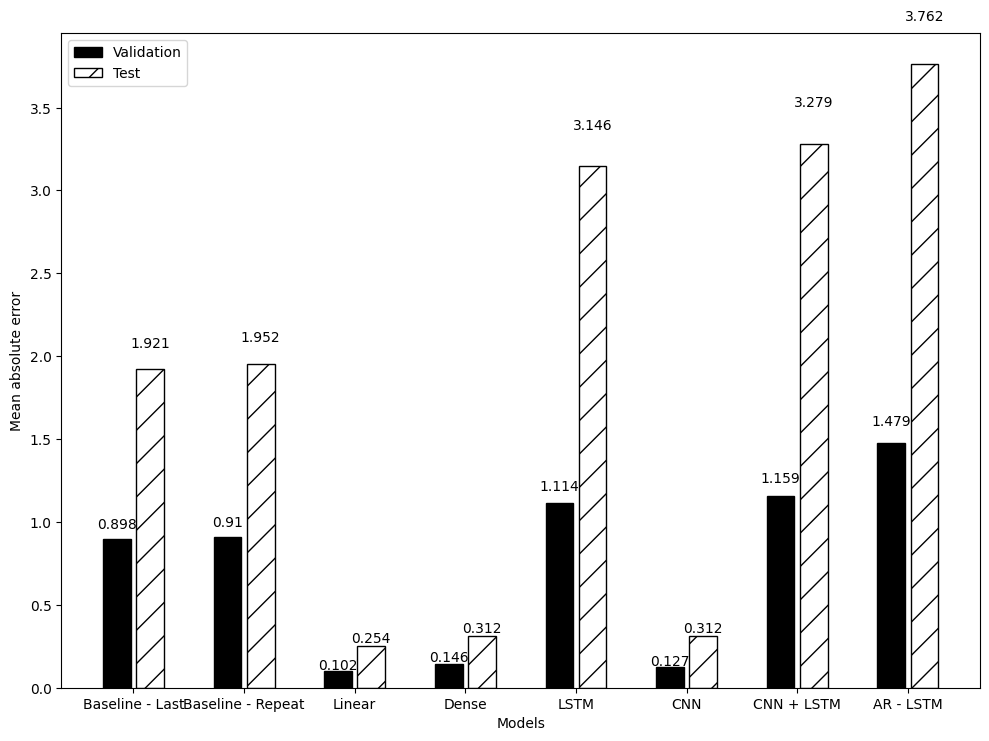

In [30]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+value*0.07, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+value*0.07, s=str(round(value, 3)), ha='center')

# plt.ylim(0, 0.33)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH18_F14_peixeiro.png', dpi=300)